# Turbulence estimation 6-beam

### Introduction

The work from [Sathe et al. 2015](https://doi.org/10.5194/amt-8-729-2015) introduces an alternative scanning strategy to be used by wind Doppler lidars for estimating turbulence. This new strategy consists of measuring the radial wind on five equally spaced azimuths with fixed elevation, different from 0 or 90 degrees,  and one additional measurement from the zenith. From those observations, the Reynolds stress tensor elements can be calculated following the method suggested developed by Sathe et al. 2015. 

This example shows how to use the lidarwind package to calculate the Reynolds stress tensor elements from the six beam observations obtained by the WindCube lidar 200s. This example is structured according to the steps listed below.

### Steps:

0) Download data from zenodo
1) Read the WindCube's data
2) Merge data from one hour of observations
3) Re-structure the data for using the wind retrieval
4) Calculate the Reynolds stress tensor elements
5) Visualisation

In [1]:
import glob
import pooch

import matplotlib.pyplot as plt
import lidarwind
from lidarwind.utilities import sample_data

### Step 0: Downloading sample data

Use `sample_data()` to download and cache some sample dataset.

In [2]:
file_list = sample_data('wc_6beam')

### Step 1 and 2: reading and merging the 6-beam data

In [3]:
file_list = sorted(file_list)
merged_ds = lidarwind.DataOperations(file_list).merged_data

/Users/jdiasneto/Projects/LST_package_name/lidarwind/data_operator.py:147: UserWarning: rename 'range' to 'range90' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.tmp90 = self.tmp90.rename({var: f"{var}90"})


Below you can see all the variables available on the original WindCube's data. Not all of them are needed for retrieving the wind profiles. Note that the variables from the vertical observations are kept separate from the slanted observations. 

In [4]:
merged_ds

<xarray.Dataset>
Dimensions:                                  (time: 715, range90: 143,
                                              range: 137)
Coordinates:
  * time                                     (time) datetime64[ns] 2021-05-13...
  * range90                                  (range90) int32 100 150 ... 7200
  * range                                    (range) int32 104 156 ... 7124 7176
Data variables: (12/34)
    scan_file                                (time) object b'(\xe1\x18\xd5\xf...
    settings_file                            (time) object b'E\xc7_t<\xb7\x10...
    res_file                                 (time) object b'7\x1bb\x06\x0f\x...
    ray_angle_resolution                     (time) float64 0.0 0.0 ... 0.0 0.0
    range_gate_length                        (time) float64 50.0 50.0 ... 50.0
    ray_accumulation_time                    (time) float64 2e+03 ... 2e+03
    ...                                       ...
    radial_wind_speed                        (time, range) float64 1.8 ... -3...
    radial_wind_speed_ci                     (time, range) float64 100.0 ... 0.0
    radial_wind_speed_status                 (time, range) float32 1.0 ... 0.0
    doppler_spectrum_width                   (time, range) float64 0.91 ... 2.92
    doppler_spectrum_mean_error              (time, range) float64 2.6 ... 55.7
    relative_beta                            (time, range) float64 1.01e-07 ....

### Step 3: re-structuring the data

The re-structured object contains all the information needed to calculate the Reynolds stress tensor elements.

In [5]:
restruct_data = lidarwind.GetRestructuredData(merged_ds)

### Step 4: Calculate the Reynolds stress tensor elements

To calculate Reynolds stress tensor elements, you need to define a time window (a frequency). Since lidarwind takes advantage of the xarray library, the frequency for calculating those elements is defined in terms of the number of profiles. However, a frequency in terms of time is more practical. In the following fuor lines, a time frequency will be related to its equivalent in terms of profile frequency.

In [6]:
# desired time windown in minutes
time_window = 5

# duration of one minute in seconds
minute_lenght = 60

# vertical observations time resolution in seconds
time_resolution = restruct_data.data_transf_90.time.diff(dim='time').values * 1e-9
time_resolution = int(time_resolution[0])

# frequency convertion from minutes to profile number
freq = (minute_lenght/time_resolution)*time_window
freq = int(freq)

Applying the 6-beam method to calculate Reynolds stress tensor elements

In [7]:
turb_data = lidarwind.SixBeamMethod(restruct_data, freq=freq, freq90=freq)

/opt/miniconda3/envs/lidarSuit/lib/python3.8/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/miniconda3/envs/lidarSuit/lib/python3.8/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Have a look at the Reynolds elements dataset

In [8]:
turb_data.var_comp_ds

<xarray.Dataset>
Dimensions:  (time: 119, range: 137)
Coordinates:
  * time     (time) datetime64[ns] 2021-05-13T12:00:14.748000 ... 2021-05-13T...
  * range    (range) int32 100 150 200 250 300 350 ... 6700 6750 6800 6850 6900
Data variables:
    var_u    (time, range) float64 4.397 -0.1946 1.142 0.9758 ... nan nan nan
    var_v    (time, range) float64 12.65 7.676 8.094 4.014 ... nan nan nan nan
    var_w    (time, range) float64 0.0812 0.2858 0.05532 0.1414 ... nan nan nan
    var_uv   (time, range) float64 9.568 10.01 2.939 -0.8213 ... nan nan nan nan
    var_uw   (time, range) float64 -0.895 -0.6348 -0.3155 ... nan nan nan
    var_vw   (time, range) float64 -0.9987 -0.7313 0.2783 0.492 ... nan nan nan

Below we will have the first impressions of the retrieved data. Note that there are negative variances, which is mathematically impossible. Those negative is a known artefact of the 6-beam method.

### Step 5: Visualisation

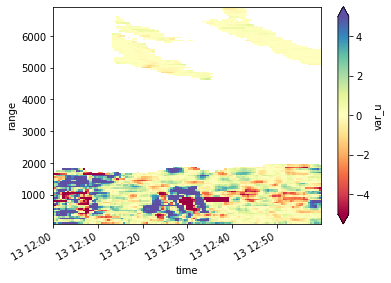

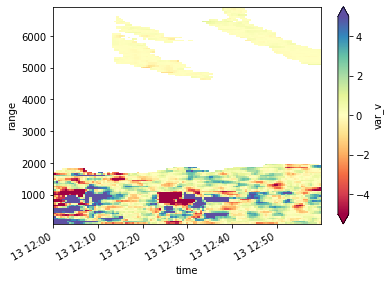

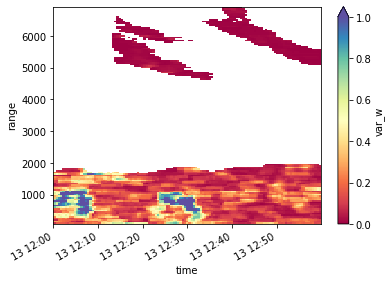

In [9]:
turb_data.var_comp_ds.var_u.plot(x='time', cmap='Spectral', vmin=-5, vmax=5)
plt.show()

turb_data.var_comp_ds.var_v.plot(x='time', cmap='Spectral', vmin=-5, vmax=5)
plt.show()

turb_data.var_comp_ds.var_w.plot(x='time', cmap='Spectral', vmin=0, vmax=1)
plt.show()